In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam
from keras.regularizers import l2

from matplotlib import pyplot as plt

### Some useful functions

In [2]:
def get_confusion_matrix(true_pos, false_pos, true_neg, false_neg):
    conf_matrix = np.array([
                            [true_pos, false_pos],
                            [false_neg, true_neg]
                           ])
    
    return pd.DataFrame(conf_matrix, columns=['1', '0'], index=['1', '0'])

In [3]:
def learning_plot(model, metric):
    
    fig = plt.figure()
    
    fig = plt.plot(model.history[metric], color='black')
    fig = plt.plot(model.history['val_'+metric], color='blue')

    plt.title('Changes in {} over training run'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend(['train', 'val'], loc='upper right')
    
    return fig

In [4]:
def learning_recall(model, positives_flag=True):
    
    if positives_flag:
        recall = [tp / (tp+fn) for tp, fn in zip(model.history['true_positives'], model.history['false_negatives'])]
        val_recall = [tp / (tp+fn) for tp, fn in zip(model.history['val_true_positives'], model.history['val_false_negatives'])]
        recall_type = 'positive'
    else:
        recall = [tn / (tn+fp) for tn, fp in zip(model.history['true_negatives'], model.history['false_positives'])]
        val_recall = [tn / (tn+fp) for tn, fp in zip(model.history['val_true_negatives'], model.history['val_false_positives'])]
        recall_type = 'negative'
        
    fig = plt.figure()
    
    fig = plt.plot(recall, color='black')
    fig = plt.plot(val_recall, color='blue')
    
    plt.title('Changes in {} recall rate over training run.'.format(recall_type))
    plt.xlabel('Epoch')
    plt.ylabel('{} recall rate'.format(recall_type))
    
    return fig

### Load and prepare data

In [5]:
df = pd.read_csv('jazz.csv', sep='|')

In [6]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]

df = df[features+['label']]

# Shuffle data to ungroup class rows
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

In [7]:
df[df['label']==1].shape

(1505, 31)

Split dataset into training, validation, and test. 60/20/20 gives ~903 positive training samples, and ~301 each of positive validation and test samples. Quite small, but hopefully big enough to be meaningful.

In [8]:
X = df[features].copy()
Y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    Y, 
                                                    stratify = Y,
                                                    test_size = 0.2,
                                                    random_state = 42
                                                   )

# Start building model

In [9]:
# First fit how to scale data for the model
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scale_model = pipeline.fit(X_train)
X_train = scale_model.transform(X_train)
X_test = scale_model.transform(X_test)

# Save for later use
dump(scale_model, 'scaler.joblib') 

['scaler.joblib']

In [10]:
regu_val = 0.005
model = Sequential()
model.add(Dense(8, input_dim=len(features), activation='relu', kernel_regularizer=l2(l2=regu_val)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=regu_val)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=regu_val)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2=regu_val)))

compile_metrics = [
                   metrics.Precision(),
                   metrics.TruePositives(),
                   metrics.TrueNegatives(),
                   metrics.FalsePositives(),
                   metrics.FalseNegatives(),
                   metrics.AUC(curve='PR')
                  ]
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=compile_metrics)

jazz_model = model.fit(
                       X_train,
                       y_train,
                       epochs = 1000,
                       batch_size = 128,
                       validation_split = 0.2,
                       shuffle = True
                      )

Epoch 1/1000
19/19 [==============================] - 1s 41ms/step - loss: 0.8075 - precision: 0.4486 - true_positives: 275.0000 - true_negatives: 1034.0000 - false_positives: 338.0000 - false_negatives: 683.0000 - auc: 0.4271 - val_loss: 0.8084 - val_precision: 0.4487 - val_true_positives: 70.0000 - val_true_negatives: 251.0000 - val_false_positives: 86.0000 - val_false_negatives: 176.0000 - val_auc: 0.4362
Epoch 2/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.8056 - precision: 0.4556 - true_positives: 267.0000 - true_negatives: 1053.0000 - false_positives: 319.0000 - false_negatives: 691.0000 - auc: 0.4304 - val_loss: 0.8068 - val_precision: 0.4795 - val_true_positives: 70.0000 - val_true_negatives: 261.0000 - val_false_positives: 76.0000 - val_false_negatives: 176.0000 - val_auc: 0.4365
Epoch 3/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.8039 - precision: 0.4604 - true_positives: 256.0000 - true_negatives: 1072.0000 - false_positives: 30

Epoch 21/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7745 - precision: 0.5592 - true_positives: 85.0000 - true_negatives: 1305.0000 - false_positives: 67.0000 - false_negatives: 873.0000 - auc: 0.4965 - val_loss: 0.7775 - val_precision: 0.5588 - val_true_positives: 19.0000 - val_true_negatives: 322.0000 - val_false_positives: 15.0000 - val_false_negatives: 227.0000 - val_auc: 0.4953
Epoch 22/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7729 - precision: 0.5510 - true_positives: 81.0000 - true_negatives: 1306.0000 - false_positives: 66.0000 - false_negatives: 877.0000 - auc: 0.4992 - val_loss: 0.7759 - val_precision: 0.5625 - val_true_positives: 18.0000 - val_true_negatives: 323.0000 - val_false_positives: 14.0000 - val_false_negatives: 228.0000 - val_auc: 0.4977
Epoch 23/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7714 - precision: 0.5612 - true_positives: 78.0000 - true_negatives: 1311.0000 - false_positives: 61.00

19/19 [==============================] - 0s 2ms/step - loss: 0.7402 - precision: 0.5686 - true_positives: 29.0000 - true_negatives: 1350.0000 - false_positives: 22.0000 - false_negatives: 929.0000 - auc: 0.5693 - val_loss: 0.7426 - val_precision: 0.5833 - val_true_positives: 7.0000 - val_true_negatives: 332.0000 - val_false_positives: 5.0000 - val_false_negatives: 239.0000 - val_auc: 0.5674
Epoch 42/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7384 - precision: 0.5800 - true_positives: 29.0000 - true_negatives: 1351.0000 - false_positives: 21.0000 - false_negatives: 929.0000 - auc: 0.5750 - val_loss: 0.7408 - val_precision: 0.5833 - val_true_positives: 7.0000 - val_true_negatives: 332.0000 - val_false_positives: 5.0000 - val_false_negatives: 239.0000 - val_auc: 0.5726
Epoch 43/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7366 - precision: 0.5918 - true_positives: 29.0000 - true_negatives: 1352.0000 - false_positives: 20.0000 - false_negativ

19/19 [==============================] - 0s 2ms/step - loss: 0.7035 - precision: 0.7547 - true_positives: 40.0000 - true_negatives: 1359.0000 - false_positives: 13.0000 - false_negatives: 918.0000 - auc: 0.6454 - val_loss: 0.7041 - val_precision: 0.7500 - val_true_positives: 9.0000 - val_true_negatives: 334.0000 - val_false_positives: 3.0000 - val_false_negatives: 237.0000 - val_auc: 0.6451
Epoch 62/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7017 - precision: 0.7647 - true_positives: 39.0000 - true_negatives: 1360.0000 - false_positives: 12.0000 - false_negatives: 919.0000 - auc: 0.6481 - val_loss: 0.7021 - val_precision: 0.8333 - val_true_positives: 10.0000 - val_true_negatives: 335.0000 - val_false_positives: 2.0000 - val_false_negatives: 236.0000 - val_auc: 0.6464
Epoch 63/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.7000 - precision: 0.7843 - true_positives: 40.0000 - true_negatives: 1361.0000 - false_positives: 11.0000 - false_negati

19/19 [==============================] - 0s 2ms/step - loss: 0.6717 - precision: 0.7751 - true_positives: 162.0000 - true_negatives: 1325.0000 - false_positives: 47.0000 - false_negatives: 796.0000 - auc: 0.6961 - val_loss: 0.6712 - val_precision: 0.6724 - val_true_positives: 39.0000 - val_true_negatives: 318.0000 - val_false_positives: 19.0000 - val_false_negatives: 207.0000 - val_auc: 0.6886
Epoch 81/1000
19/19 [==============================] - ETA: 0s - loss: 0.6696 - precision: 0.7692 - true_positives: 10.0000 - true_negatives: 71.0000 - false_positives: 3.0000 - false_negatives: 44.0000 - auc: 0.71 - 0s 2ms/step - loss: 0.6702 - precision: 0.7773 - true_positives: 171.0000 - true_negatives: 1323.0000 - false_positives: 49.0000 - false_negatives: 787.0000 - auc: 0.7006 - val_loss: 0.6696 - val_precision: 0.6935 - val_true_positives: 43.0000 - val_true_negatives: 318.0000 - val_false_positives: 19.0000 - val_false_negatives: 203.0000 - val_auc: 0.6928
Epoch 82/1000
19/19 [=========

19/19 [==============================] - 0s 2ms/step - loss: 0.6453 - precision: 0.7789 - true_positives: 398.0000 - true_negatives: 1259.0000 - false_positives: 113.0000 - false_negatives: 560.0000 - auc: 0.7327 - val_loss: 0.6462 - val_precision: 0.7692 - val_true_positives: 100.0000 - val_true_negatives: 307.0000 - val_false_positives: 30.0000 - val_false_negatives: 146.0000 - val_auc: 0.7086
Epoch 100/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6440 - precision: 0.7820 - true_positives: 409.0000 - true_negatives: 1258.0000 - false_positives: 114.0000 - false_negatives: 549.0000 - auc: 0.7337 - val_loss: 0.6451 - val_precision: 0.7710 - val_true_positives: 101.0000 - val_true_negatives: 307.0000 - val_false_positives: 30.0000 - val_false_negatives: 145.0000 - val_auc: 0.7071
Epoch 101/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6428 - precision: 0.7801 - true_positives: 415.0000 - true_negatives: 1255.0000 - false_positives: 117.0000 -

Epoch 119/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6219 - precision: 0.7763 - true_positives: 517.0000 - true_negatives: 1223.0000 - false_positives: 149.0000 - false_negatives: 441.0000 - auc: 0.7543 - val_loss: 0.6254 - val_precision: 0.7605 - val_true_positives: 127.0000 - val_true_negatives: 297.0000 - val_false_positives: 40.0000 - val_false_negatives: 119.0000 - val_auc: 0.7521
Epoch 120/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6208 - precision: 0.7776 - true_positives: 521.0000 - true_negatives: 1223.0000 - false_positives: 149.0000 - false_negatives: 437.0000 - auc: 0.7592 - val_loss: 0.6245 - val_precision: 0.7529 - val_true_positives: 128.0000 - val_true_negatives: 295.0000 - val_false_positives: 42.0000 - val_false_negatives: 118.0000 - val_auc: 0.7560
Epoch 121/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6198 - precision: 0.7766 - true_positives: 525.0000 - true_negatives: 1221.0000 - false_positi

Epoch 139/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6032 - precision: 0.7672 - true_positives: 570.0000 - true_negatives: 1199.0000 - false_positives: 173.0000 - false_negatives: 388.0000 - auc: 0.7658 - val_loss: 0.6091 - val_precision: 0.7437 - val_true_positives: 148.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 98.0000 - val_auc: 0.7699
Epoch 140/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.6024 - precision: 0.7661 - true_positives: 570.0000 - true_negatives: 1198.0000 - false_positives: 174.0000 - false_negatives: 388.0000 - auc: 0.7659 - val_loss: 0.6084 - val_precision: 0.7475 - val_true_positives: 151.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 95.0000 - val_auc: 0.7637
Epoch 141/1000
19/19 [==============================] - ETA: 0s - loss: 0.6292 - precision: 0.7568 - true_positives: 28.0000 - true_negatives: 61.0000 - false_positives: 9.00

19/19 [==============================] - 0s 2ms/step - loss: 0.5884 - precision: 0.7556 - true_positives: 603.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 355.0000 - auc: 0.7698 - val_loss: 0.5958 - val_precision: 0.7619 - val_true_positives: 160.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 86.0000 - val_auc: 0.7663
Epoch 159/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5876 - precision: 0.7575 - true_positives: 609.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 349.0000 - auc: 0.7661 - val_loss: 0.5951 - val_precision: 0.7630 - val_true_positives: 161.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 85.0000 - val_auc: 0.7633
Epoch 160/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5870 - precision: 0.7571 - true_positives: 611.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.5744 - precision: 0.7567 - true_positives: 653.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 305.0000 - auc: 0.7553 - val_loss: 0.5822 - val_precision: 0.7679 - val_true_positives: 172.0000 - val_true_negatives: 285.0000 - val_false_positives: 52.0000 - val_false_negatives: 74.0000 - val_auc: 0.7585
Epoch 178/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5737 - precision: 0.7566 - true_positives: 656.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 302.0000 - auc: 0.7540 - val_loss: 0.5815 - val_precision: 0.7679 - val_true_positives: 172.0000 - val_true_negatives: 285.0000 - val_false_positives: 52.0000 - val_false_negatives: 74.0000 - val_auc: 0.7598
Epoch 179/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5729 - precision: 0.7569 - true_positives: 660.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.5612 - precision: 0.7508 - true_positives: 696.0000 - true_negatives: 1141.0000 - false_positives: 231.0000 - false_negatives: 262.0000 - auc: 0.7517 - val_loss: 0.5689 - val_precision: 0.7652 - val_true_positives: 176.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 70.0000 - val_auc: 0.7574
Epoch 197/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5606 - precision: 0.7511 - true_positives: 697.0000 - true_negatives: 1141.0000 - false_positives: 231.0000 - false_negatives: 261.0000 - auc: 0.7527 - val_loss: 0.5681 - val_precision: 0.7652 - val_true_positives: 176.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 70.0000 - val_auc: 0.7580
Epoch 198/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5599 - precision: 0.7489 - true_positives: 698.0000 - true_negatives: 1138.0000 - false_positives: 234.0000 - f

Epoch 216/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5484 - precision: 0.7414 - true_positives: 711.0000 - true_negatives: 1124.0000 - false_positives: 248.0000 - false_negatives: 247.0000 - auc: 0.7562 - val_loss: 0.5563 - val_precision: 0.7660 - val_true_positives: 180.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 66.0000 - val_auc: 0.7599
Epoch 217/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5479 - precision: 0.7422 - true_positives: 711.0000 - true_negatives: 1125.0000 - false_positives: 247.0000 - false_negatives: 247.0000 - auc: 0.7560 - val_loss: 0.5557 - val_precision: 0.7660 - val_true_positives: 180.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 66.0000 - val_auc: 0.7602
Epoch 218/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5473 - precision: 0.7406 - true_positives: 711.0000 - true_negatives: 1123.0000 - false_positive

Epoch 236/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5375 - precision: 0.7375 - true_positives: 722.0000 - true_negatives: 1115.0000 - false_positives: 257.0000 - false_negatives: 236.0000 - auc: 0.7614 - val_loss: 0.5457 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.7671
Epoch 237/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5370 - precision: 0.7387 - true_positives: 721.0000 - true_negatives: 1117.0000 - false_positives: 255.0000 - false_negatives: 237.0000 - auc: 0.7614 - val_loss: 0.5453 - val_precision: 0.7593 - val_true_positives: 183.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 63.0000 - val_auc: 0.7672
Epoch 238/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5366 - precision: 0.7382 - true_positives: 722.0000 - true_negatives: 1116.0000 - false_positive

Epoch 256/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5285 - precision: 0.7388 - true_positives: 727.0000 - true_negatives: 1115.0000 - false_positives: 257.0000 - false_negatives: 231.0000 - auc: 0.7700 - val_loss: 0.5372 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.7749
Epoch 257/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5281 - precision: 0.7391 - true_positives: 728.0000 - true_negatives: 1115.0000 - false_positives: 257.0000 - false_negatives: 230.0000 - auc: 0.7689 - val_loss: 0.5367 - val_precision: 0.7654 - val_true_positives: 186.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 60.0000 - val_auc: 0.7761
Epoch 258/1000
19/19 [==============================] - ETA: 0s - loss: 0.5726 - precision: 0.8226 - true_positives: 51.0000 - true_negatives: 49.0000 - false_positives: 11.0

19/19 [==============================] - 0s 2ms/step - loss: 0.5210 - precision: 0.7427 - true_positives: 733.0000 - true_negatives: 1118.0000 - false_positives: 254.0000 - false_negatives: 225.0000 - auc: 0.7789 - val_loss: 0.5307 - val_precision: 0.7769 - val_true_positives: 188.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 58.0000 - val_auc: 0.7820
Epoch 276/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5206 - precision: 0.7432 - true_positives: 735.0000 - true_negatives: 1118.0000 - false_positives: 254.0000 - false_negatives: 223.0000 - auc: 0.7794 - val_loss: 0.5304 - val_precision: 0.7759 - val_true_positives: 187.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 59.0000 - val_auc: 0.7818
Epoch 277/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5203 - precision: 0.7437 - true_positives: 734.0000 - true_negatives: 1119.0000 - false_positives: 253.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.5145 - precision: 0.7417 - true_positives: 741.0000 - true_negatives: 1114.0000 - false_positives: 258.0000 - false_negatives: 217.0000 - auc: 0.7881 - val_loss: 0.5255 - val_precision: 0.7746 - val_true_positives: 189.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 57.0000 - val_auc: 0.7903
Epoch 295/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5142 - precision: 0.7440 - true_positives: 741.0000 - true_negatives: 1117.0000 - false_positives: 255.0000 - false_negatives: 217.0000 - auc: 0.7888 - val_loss: 0.5252 - val_precision: 0.7778 - val_true_positives: 189.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 57.0000 - val_auc: 0.7904
Epoch 296/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5139 - precision: 0.7437 - true_positives: 740.0000 - true_negatives: 1117.0000 - false_positives: 255.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.5089 - precision: 0.7457 - true_positives: 742.0000 - true_negatives: 1119.0000 - false_positives: 253.0000 - false_negatives: 216.0000 - auc: 0.7976 - val_loss: 0.5214 - val_precision: 0.7810 - val_true_positives: 189.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 57.0000 - val_auc: 0.7964
Epoch 314/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5086 - precision: 0.7457 - true_positives: 742.0000 - true_negatives: 1119.0000 - false_positives: 253.0000 - false_negatives: 216.0000 - auc: 0.7986 - val_loss: 0.5212 - val_precision: 0.7810 - val_true_positives: 189.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 57.0000 - val_auc: 0.7945
Epoch 315/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5084 - precision: 0.7457 - true_positives: 742.0000 - true_negatives: 1119.0000 - false_positives: 253.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.5041 - precision: 0.7477 - true_positives: 744.0000 - true_negatives: 1121.0000 - false_positives: 251.0000 - false_negatives: 214.0000 - auc: 0.8060 - val_loss: 0.5184 - val_precision: 0.7828 - val_true_positives: 191.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 55.0000 - val_auc: 0.7976
Epoch 333/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5038 - precision: 0.7475 - true_positives: 743.0000 - true_negatives: 1121.0000 - false_positives: 251.0000 - false_negatives: 215.0000 - auc: 0.8064 - val_loss: 0.5182 - val_precision: 0.7828 - val_true_positives: 191.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 55.0000 - val_auc: 0.7980
Epoch 334/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5036 - precision: 0.7472 - true_positives: 742.0000 - true_negatives: 1121.0000 - false_positives: 251.0000 - f

Epoch 352/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4993 - precision: 0.7520 - true_positives: 743.0000 - true_negatives: 1127.0000 - false_positives: 245.0000 - false_negatives: 215.0000 - auc: 0.8153 - val_loss: 0.5157 - val_precision: 0.7917 - val_true_positives: 190.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 56.0000 - val_auc: 0.8018
Epoch 353/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4991 - precision: 0.7515 - true_positives: 741.0000 - true_negatives: 1127.0000 - false_positives: 245.0000 - false_negatives: 217.0000 - auc: 0.8152 - val_loss: 0.5156 - val_precision: 0.7908 - val_true_positives: 189.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 57.0000 - val_auc: 0.8016
Epoch 354/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4989 - precision: 0.7515 - true_positives: 741.0000 - true_negatives: 1127.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4952 - precision: 0.7520 - true_positives: 740.0000 - true_negatives: 1128.0000 - false_positives: 244.0000 - false_negatives: 218.0000 - auc: 0.8220 - val_loss: 0.5136 - val_precision: 0.7875 - val_true_positives: 189.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 57.0000 - val_auc: 0.8031
Epoch 372/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4949 - precision: 0.7520 - true_positives: 740.0000 - true_negatives: 1128.0000 - false_positives: 244.0000 - false_negatives: 218.0000 - auc: 0.8226 - val_loss: 0.5135 - val_precision: 0.7884 - val_true_positives: 190.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 56.0000 - val_auc: 0.8034
Epoch 373/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4947 - precision: 0.7520 - true_positives: 740.0000 - true_negatives: 1128.0000 - false_positives: 244.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.4915 - precision: 0.7536 - true_positives: 740.0000 - true_negatives: 1130.0000 - false_positives: 242.0000 - false_negatives: 218.0000 - auc: 0.8272 - val_loss: 0.5119 - val_precision: 0.7908 - val_true_positives: 189.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 57.0000 - val_auc: 0.8080
Epoch 391/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4913 - precision: 0.7543 - true_positives: 740.0000 - true_negatives: 1131.0000 - false_positives: 241.0000 - false_negatives: 218.0000 - auc: 0.8277 - val_loss: 0.5118 - val_precision: 0.7899 - val_true_positives: 188.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 58.0000 - val_auc: 0.8084
Epoch 392/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4911 - precision: 0.7543 - true_positives: 740.0000 - true_negatives: 1131.0000 - false_positives: 241.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.4880 - precision: 0.7559 - true_positives: 737.0000 - true_negatives: 1134.0000 - false_positives: 238.0000 - false_negatives: 221.0000 - auc: 0.8320 - val_loss: 0.5104 - val_precision: 0.7941 - val_true_positives: 189.0000 - val_true_negatives: 288.0000 - val_false_positives: 49.0000 - val_false_negatives: 57.0000 - val_auc: 0.8096
Epoch 410/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4878 - precision: 0.7567 - true_positives: 737.0000 - true_negatives: 1135.0000 - false_positives: 237.0000 - false_negatives: 221.0000 - auc: 0.8324 - val_loss: 0.5104 - val_precision: 0.7941 - val_true_positives: 189.0000 - val_true_negatives: 288.0000 - val_false_positives: 49.0000 - val_false_negatives: 57.0000 - val_auc: 0.8101
Epoch 411/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4876 - precision: 0.7567 - true_positives: 737.0000 - true_negatives: 1135.0000 - false_positives: 237.0000 - f

Epoch 429/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4846 - precision: 0.7606 - true_positives: 737.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 221.0000 - auc: 0.8367 - val_loss: 0.5091 - val_precision: 0.7924 - val_true_positives: 187.0000 - val_true_negatives: 288.0000 - val_false_positives: 49.0000 - val_false_negatives: 59.0000 - val_auc: 0.8109
Epoch 430/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4844 - precision: 0.7598 - true_positives: 737.0000 - true_negatives: 1139.0000 - false_positives: 233.0000 - false_negatives: 221.0000 - auc: 0.8368 - val_loss: 0.5090 - val_precision: 0.7890 - val_true_positives: 187.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 59.0000 - val_auc: 0.8120
Epoch 431/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4842 - precision: 0.7600 - true_positives: 738.0000 - true_negatives: 1139.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4816 - precision: 0.7680 - true_positives: 735.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 223.0000 - auc: 0.8396 - val_loss: 0.5086 - val_precision: 0.7848 - val_true_positives: 186.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 60.0000 - val_auc: 0.8102
Epoch 449/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4814 - precision: 0.7672 - true_positives: 735.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 223.0000 - auc: 0.8400 - val_loss: 0.5087 - val_precision: 0.7839 - val_true_positives: 185.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 61.0000 - val_auc: 0.8111
Epoch 450/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4813 - precision: 0.7672 - true_positives: 735.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - f

Epoch 468/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4787 - precision: 0.7684 - true_positives: 740.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 218.0000 - auc: 0.8438 - val_loss: 0.5080 - val_precision: 0.7815 - val_true_positives: 186.0000 - val_true_negatives: 285.0000 - val_false_positives: 52.0000 - val_false_negatives: 60.0000 - val_auc: 0.8121
Epoch 469/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4785 - precision: 0.7684 - true_positives: 740.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 218.0000 - auc: 0.8439 - val_loss: 0.5080 - val_precision: 0.7815 - val_true_positives: 186.0000 - val_true_negatives: 285.0000 - val_false_positives: 52.0000 - val_false_negatives: 60.0000 - val_auc: 0.8124
Epoch 470/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4784 - precision: 0.7684 - true_positives: 740.0000 - true_negatives: 1149.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4763 - precision: 0.7688 - true_positives: 738.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 220.0000 - auc: 0.8460 - val_loss: 0.5078 - val_precision: 0.7782 - val_true_positives: 186.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 60.0000 - val_auc: 0.8112
Epoch 488/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4762 - precision: 0.7682 - true_positives: 739.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 219.0000 - auc: 0.8463 - val_loss: 0.5077 - val_precision: 0.7782 - val_true_positives: 186.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 60.0000 - val_auc: 0.8125
Epoch 489/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4760 - precision: 0.7684 - true_positives: 740.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - f

Epoch 507/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4740 - precision: 0.7674 - true_positives: 739.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 219.0000 - auc: 0.8485 - val_loss: 0.5070 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8125
Epoch 508/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4739 - precision: 0.7669 - true_positives: 737.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 221.0000 - auc: 0.8485 - val_loss: 0.5070 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8138
Epoch 509/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4738 - precision: 0.7672 - true_positives: 738.0000 - true_negatives: 1148.0000 - false_positive

Epoch 527/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4719 - precision: 0.7682 - true_positives: 739.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 219.0000 - auc: 0.8504 - val_loss: 0.5068 - val_precision: 0.7773 - val_true_positives: 185.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 61.0000 - val_auc: 0.8130
Epoch 528/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4718 - precision: 0.7690 - true_positives: 739.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 219.0000 - auc: 0.8505 - val_loss: 0.5068 - val_precision: 0.7773 - val_true_positives: 185.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 61.0000 - val_auc: 0.8132
Epoch 529/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4717 - precision: 0.7684 - true_positives: 740.0000 - true_negatives: 1149.0000 - false_positive

Epoch 547/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4700 - precision: 0.7705 - true_positives: 742.0000 - true_negatives: 1151.0000 - false_positives: 221.0000 - false_negatives: 216.0000 - auc: 0.8524 - val_loss: 0.5065 - val_precision: 0.7773 - val_true_positives: 185.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 61.0000 - val_auc: 0.8141
Epoch 548/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4698 - precision: 0.7713 - true_positives: 742.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 216.0000 - auc: 0.8527 - val_loss: 0.5066 - val_precision: 0.7792 - val_true_positives: 187.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 59.0000 - val_auc: 0.8142
Epoch 549/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4698 - precision: 0.7699 - true_positives: 743.0000 - true_negatives: 1150.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4683 - precision: 0.7711 - true_positives: 741.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 217.0000 - auc: 0.8538 - val_loss: 0.5065 - val_precision: 0.7782 - val_true_positives: 186.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 60.0000 - val_auc: 0.8156
Epoch 567/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4682 - precision: 0.7703 - true_positives: 741.0000 - true_negatives: 1151.0000 - false_positives: 221.0000 - false_negatives: 217.0000 - auc: 0.8541 - val_loss: 0.5065 - val_precision: 0.7773 - val_true_positives: 185.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 61.0000 - val_auc: 0.8154
Epoch 568/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4681 - precision: 0.7695 - true_positives: 741.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - f

Epoch 586/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4666 - precision: 0.7707 - true_positives: 743.0000 - true_negatives: 1151.0000 - false_positives: 221.0000 - false_negatives: 215.0000 - auc: 0.8558 - val_loss: 0.5063 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8146
Epoch 587/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4666 - precision: 0.7692 - true_positives: 743.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 215.0000 - auc: 0.8560 - val_loss: 0.5063 - val_precision: 0.7708 - val_true_positives: 185.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 61.0000 - val_auc: 0.8155
Epoch 588/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4665 - precision: 0.7707 - true_positives: 743.0000 - true_negatives: 1151.0000 - false_positive

Epoch 606/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4651 - precision: 0.7697 - true_positives: 742.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 216.0000 - auc: 0.8569 - val_loss: 0.5061 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8165
Epoch 607/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4650 - precision: 0.7716 - true_positives: 740.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 218.0000 - auc: 0.8570 - val_loss: 0.5062 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8164
Epoch 608/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4649 - precision: 0.7703 - true_positives: 741.0000 - true_negatives: 1151.0000 - false_positive

Epoch 626/1000
19/19 [==============================] - ETA: 0s - loss: 0.5602 - precision: 0.7500 - true_positives: 42.0000 - true_negatives: 57.0000 - false_positives: 14.0000 - false_negatives: 15.0000 - auc: 0.791 - 0s 2ms/step - loss: 0.4637 - precision: 0.7732 - true_positives: 740.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 218.0000 - auc: 0.8581 - val_loss: 0.5061 - val_precision: 0.7764 - val_true_positives: 184.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 62.0000 - val_auc: 0.8186
Epoch 627/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4636 - precision: 0.7735 - true_positives: 741.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 217.0000 - auc: 0.8583 - val_loss: 0.5061 - val_precision: 0.7754 - val_true_positives: 183.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 63.0000 - val_auc: 0.8156
Epoch 628/

19/19 [==============================] - 0s 2ms/step - loss: 0.4623 - precision: 0.7754 - true_positives: 739.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - false_negatives: 219.0000 - auc: 0.8593 - val_loss: 0.5061 - val_precision: 0.7754 - val_true_positives: 183.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 63.0000 - val_auc: 0.8167
Epoch 646/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4623 - precision: 0.7767 - true_positives: 741.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 217.0000 - auc: 0.8595 - val_loss: 0.5059 - val_precision: 0.7754 - val_true_positives: 183.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 63.0000 - val_auc: 0.8177
Epoch 647/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4622 - precision: 0.7764 - true_positives: 743.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - f

Epoch 665/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4610 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 216.0000 - auc: 0.8604 - val_loss: 0.5058 - val_precision: 0.7689 - val_true_positives: 183.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 63.0000 - val_auc: 0.8197
Epoch 666/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4609 - precision: 0.7770 - true_positives: 742.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 216.0000 - auc: 0.8605 - val_loss: 0.5058 - val_precision: 0.7722 - val_true_positives: 183.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 63.0000 - val_auc: 0.8196
Epoch 667/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4608 - precision: 0.7762 - true_positives: 742.0000 - true_negatives: 1158.0000 - false_positive

Epoch 685/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4597 - precision: 0.7762 - true_positives: 742.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - false_negatives: 216.0000 - auc: 0.8620 - val_loss: 0.5052 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8196
Epoch 686/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4596 - precision: 0.7759 - true_positives: 741.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - false_negatives: 217.0000 - auc: 0.8619 - val_loss: 0.5052 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8206
Epoch 687/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4595 - precision: 0.7764 - true_positives: 743.0000 - true_negatives: 1158.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4585 - precision: 0.7784 - true_positives: 741.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 217.0000 - auc: 0.8634 - val_loss: 0.5049 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8200
Epoch 705/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4584 - precision: 0.7784 - true_positives: 741.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 217.0000 - auc: 0.8636 - val_loss: 0.5050 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8200
Epoch 706/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4583 - precision: 0.7781 - true_positives: 740.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.4573 - precision: 0.7827 - true_positives: 742.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 216.0000 - auc: 0.8647 - val_loss: 0.5046 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8210
Epoch 724/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4572 - precision: 0.7833 - true_positives: 741.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 217.0000 - auc: 0.8647 - val_loss: 0.5046 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8209
Epoch 725/1000
19/19 [==============================] - ETA: 0s - loss: 0.4592 - precision: 0.7333 - true_positives: 33.0000 - true_negatives: 64.0000 - false_positives: 12.0000 - false_neg

Epoch 742/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4562 - precision: 0.7844 - true_positives: 742.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 216.0000 - auc: 0.8655 - val_loss: 0.5046 - val_precision: 0.7708 - val_true_positives: 185.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 61.0000 - val_auc: 0.8220
Epoch 743/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4561 - precision: 0.7844 - true_positives: 742.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 216.0000 - auc: 0.8656 - val_loss: 0.5046 - val_precision: 0.7718 - val_true_positives: 186.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 60.0000 - val_auc: 0.8219
Epoch 744/1000
19/19 [==============================] - ETA: 0s - loss: 0.4744 - precision: 0.7966 - true_positives: 47.0000 - true_negatives: 62.0000 - false_positives: 12.0

Epoch 761/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4552 - precision: 0.7858 - true_positives: 741.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 217.0000 - auc: 0.8666 - val_loss: 0.5047 - val_precision: 0.7718 - val_true_positives: 186.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 60.0000 - val_auc: 0.8206
Epoch 762/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4551 - precision: 0.7839 - true_positives: 740.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 218.0000 - auc: 0.8669 - val_loss: 0.5048 - val_precision: 0.7718 - val_true_positives: 186.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 60.0000 - val_auc: 0.8207
Epoch 763/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4550 - precision: 0.7843 - true_positives: 738.0000 - true_negatives: 1169.0000 - false_positive

Epoch 781/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4541 - precision: 0.7835 - true_positives: 742.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 216.0000 - auc: 0.8679 - val_loss: 0.5047 - val_precision: 0.7686 - val_true_positives: 186.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 60.0000 - val_auc: 0.8195
Epoch 782/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4541 - precision: 0.7819 - true_positives: 742.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 216.0000 - auc: 0.8678 - val_loss: 0.5048 - val_precision: 0.7686 - val_true_positives: 186.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 60.0000 - val_auc: 0.8199
Epoch 783/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4540 - precision: 0.7860 - true_positives: 742.0000 - true_negatives: 1170.0000 - false_positive

Epoch 801/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4531 - precision: 0.7837 - true_positives: 739.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 219.0000 - auc: 0.8687 - val_loss: 0.5054 - val_precision: 0.7708 - val_true_positives: 185.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 61.0000 - val_auc: 0.8196
Epoch 802/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4530 - precision: 0.7853 - true_positives: 739.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 219.0000 - auc: 0.8686 - val_loss: 0.5054 - val_precision: 0.7708 - val_true_positives: 185.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 61.0000 - val_auc: 0.8198
Epoch 803/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4530 - precision: 0.7862 - true_positives: 739.0000 - true_negatives: 1171.0000 - false_positive

Epoch 821/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4521 - precision: 0.7868 - true_positives: 738.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 220.0000 - auc: 0.8697 - val_loss: 0.5059 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8187
Epoch 822/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4520 - precision: 0.7866 - true_positives: 737.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 221.0000 - auc: 0.8697 - val_loss: 0.5058 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8189
Epoch 823/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4520 - precision: 0.7843 - true_positives: 738.0000 - true_negatives: 1169.0000 - false_positive

Epoch 841/1000
19/19 [==============================] - ETA: 0s - loss: 0.4633 - precision: 0.8000 - true_positives: 44.0000 - true_negatives: 59.0000 - false_positives: 11.0000 - false_negatives: 14.0000 - auc: 0.895 - 0s 2ms/step - loss: 0.4511 - precision: 0.7862 - true_positives: 739.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 219.0000 - auc: 0.8707 - val_loss: 0.5062 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8179
Epoch 842/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4511 - precision: 0.7857 - true_positives: 737.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 221.0000 - auc: 0.8706 - val_loss: 0.5063 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8186
Epoch 843/

19/19 [==============================] - 0s 2ms/step - loss: 0.4501 - precision: 0.7878 - true_positives: 735.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 223.0000 - auc: 0.8717 - val_loss: 0.5068 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8187
Epoch 861/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4500 - precision: 0.7869 - true_positives: 735.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 223.0000 - auc: 0.8719 - val_loss: 0.5068 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8184
Epoch 862/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4500 - precision: 0.7872 - true_positives: 736.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - f

19/19 [==============================] - 0s 2ms/step - loss: 0.4492 - precision: 0.7831 - true_positives: 740.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 218.0000 - auc: 0.8728 - val_loss: 0.5073 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8187
Epoch 880/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4492 - precision: 0.7856 - true_positives: 740.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 218.0000 - auc: 0.8730 - val_loss: 0.5073 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8189
Epoch 881/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4492 - precision: 0.7882 - true_positives: 737.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - f

Epoch 899/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4484 - precision: 0.7910 - true_positives: 742.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 216.0000 - auc: 0.8731 - val_loss: 0.5078 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8185
Epoch 900/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4484 - precision: 0.7902 - true_positives: 742.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 216.0000 - auc: 0.8734 - val_loss: 0.5079 - val_precision: 0.7741 - val_true_positives: 185.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 61.0000 - val_auc: 0.8161
Epoch 901/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4483 - precision: 0.7895 - true_positives: 739.0000 - true_negatives: 1175.0000 - false_positive

Epoch 919/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4476 - precision: 0.7878 - true_positives: 739.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 219.0000 - auc: 0.8741 - val_loss: 0.5086 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8171
Epoch 920/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4476 - precision: 0.7870 - true_positives: 739.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 219.0000 - auc: 0.8741 - val_loss: 0.5086 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8172
Epoch 921/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4475 - precision: 0.7876 - true_positives: 738.0000 - true_negatives: 1173.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4469 - precision: 0.7910 - true_positives: 738.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 220.0000 - auc: 0.8747 - val_loss: 0.5092 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8166
Epoch 939/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4469 - precision: 0.7881 - true_positives: 740.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 218.0000 - auc: 0.8748 - val_loss: 0.5094 - val_precision: 0.7731 - val_true_positives: 184.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 62.0000 - val_auc: 0.8167
Epoch 940/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4468 - precision: 0.7878 - true_positives: 739.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - f

Epoch 958/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4461 - precision: 0.7862 - true_positives: 739.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 219.0000 - auc: 0.8753 - val_loss: 0.5099 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8164
Epoch 959/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4461 - precision: 0.7862 - true_positives: 739.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 219.0000 - auc: 0.8754 - val_loss: 0.5097 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8164
Epoch 960/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4460 - precision: 0.7878 - true_positives: 739.0000 - true_negatives: 1173.0000 - false_positive

19/19 [==============================] - 0s 2ms/step - loss: 0.4454 - precision: 0.7868 - true_positives: 738.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 220.0000 - auc: 0.8757 - val_loss: 0.5101 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8161
Epoch 978/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4453 - precision: 0.7876 - true_positives: 738.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 220.0000 - auc: 0.8759 - val_loss: 0.5102 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8150
Epoch 979/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4453 - precision: 0.7859 - true_positives: 738.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - f

Epoch 997/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4447 - precision: 0.7853 - true_positives: 739.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 219.0000 - auc: 0.8765 - val_loss: 0.5106 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8155
Epoch 998/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4446 - precision: 0.7859 - true_positives: 738.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 220.0000 - auc: 0.8765 - val_loss: 0.5106 - val_precision: 0.7699 - val_true_positives: 184.0000 - val_true_negatives: 282.0000 - val_false_positives: 55.0000 - val_false_negatives: 62.0000 - val_auc: 0.8151
Epoch 999/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.4446 - precision: 0.7862 - true_positives: 739.0000 - true_negatives: 1171.0000 - false_positive

# Evaluate model on validation set

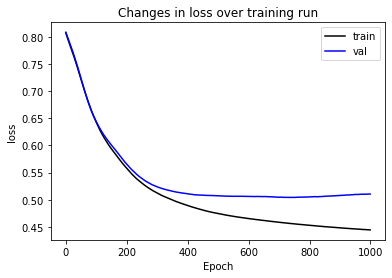

In [11]:
learning_plot(jazz_model, 'loss')

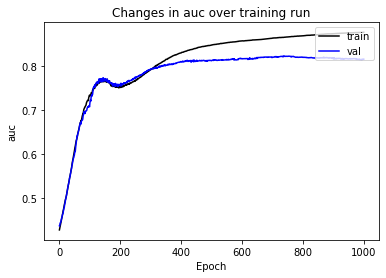

In [12]:
learning_plot(jazz_model, 'auc')

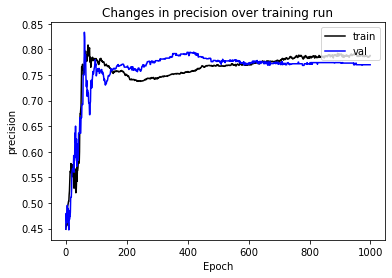

In [13]:
learning_plot(jazz_model, 'precision')

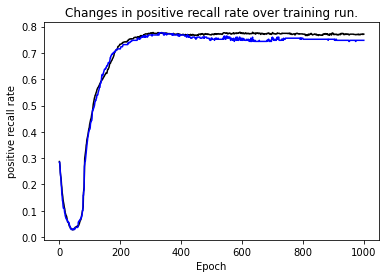

In [14]:
learning_recall(jazz_model, True)

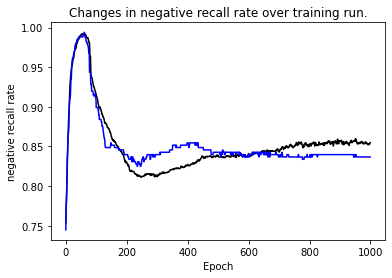

In [15]:
learning_recall(jazz_model, False)

In [16]:
loss = jazz_model.history['loss'][-1]
val_loss = jazz_model.history['val_loss'][-1]
print('Loss for training set is {}, while loss for validation set is {}. This gives a difference of {}'\
      .format(
              round(loss,4),
              round(val_loss,4), 
              round(val_loss-loss, 4)))

Loss for training set is 0.4446, while loss for validation set is 0.5105. This gives a difference of 0.0659


In [17]:
auc = jazz_model.history['auc'][-1]
val_auc = jazz_model.history['val_auc'][-1]
print('AUC for training set is {}, while AUC for validation set is {}. This gives a difference of {}'\
      .format(round(auc, 2), round(val_auc, 2), round(auc-val_auc,2)))

AUC for training set is 0.88, while AUC for validation set is 0.82. This gives a difference of 0.06


In [18]:
true_positives_val = jazz_model.history['val_true_positives'][-1]
false_positives_val = jazz_model.history['val_false_positives'][-1]
true_negatives_val = jazz_model.history['val_true_negatives'][-1]
false_negatives_val = jazz_model.history['val_false_negatives'][-1]

val_conf_matrix = get_confusion_matrix(
                                       true_positives_val,
                                       false_positives_val,
                                       true_negatives_val,
                                       false_negatives_val
                                       )

print('Confusion_matrix:\n{}'.format(val_conf_matrix))

Confusion_matrix:
       1      0
1  184.0   55.0
0   62.0  282.0


In [19]:
print('True recall rate is {}'\
      .format(round(val_conf_matrix.loc['1', '1']/(val_conf_matrix.loc['1', '1']+val_conf_matrix.loc['0', '1']),2)))
print('Precision is {}'.format(jazz_model.history['val_precision'][-1]))

True recall rate is 0.75
Precision is 0.7698744535446167


Looks very promising on validation set! Let's check test set

In [20]:
loss_test, precision_test, true_positives_test, true_negatives_test, false_positives_test, false_negatives_test, auc_test = model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 841us/step - loss: 0.5075 - precision: 0.7534 - true_positives: 223.0000 - true_negatives: 355.0000 - false_positives: 73.0000 - false_negatives: 78.0000 - auc: 0.8168


In [21]:
print('AUC for test set is {}.'.format(round(auc_test,2)))

AUC for test set is 0.82.


In [22]:
confusion_matrix = get_confusion_matrix(
                                        true_positives_test,
                                        false_positives_test,
                                        true_negatives_test,
                                        false_negatives_test
                                       )

In [23]:
print(confusion_matrix)

       1      0
1  223.0   73.0
0   78.0  355.0


In [24]:
print(
      'True recall rate is {}'\
      .format(round(
                    confusion_matrix.loc['1', '1']/
                    (confusion_matrix.loc['1', '1']+confusion_matrix.loc['0', '1']),
                    2
                   )
             )
     )
print('Precision is {}'.format(round(precision_test,2)))

True recall rate is 0.74
Precision is 0.75


# Save model

In [25]:
model.save('jazz_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: jazz_model\assets
